# Assignment #5 - Deep Learning

### <font color="red"> DUE: Apr 19 (Thursday) 11:00 pm </font>  

<font color="blue"> Sagar Nandu </font>

In [1]:
import pandas as pd
import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.gridspec as gridspec
%matplotlib inline

In [2]:
import tensorflow as tf
# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
from sklearn import metrics

def getAllPreformanceMeasures(output, target):
    target = target.flatten() # if target vector is not one dimentional in axis = 1
    CM = metrics.confusion_matrix(output, target) #creating confusion matrix
    TN = CM[0][0] # True Negatives
    FN = CM[1][0] # False Negatives
    TP = CM[1][1] # True Positives
    FP = CM[0][1] # False Positives
    return (TP+TN)*100/output.shape[0],(TP)*100/(TP+FP),(TP)*100/(TP+FN) # Returns (accuracy, precesion and recall)
    

In [4]:
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = b"<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

#### Some Activation Functions

In [5]:
def step(x):
    return 1 if x > 0 else -1

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return x if x > 0 else 0

def leak_relu(x):
    return x if x > 0 else 0.01 * x

def softplus(x):
    return np.log(1+np.exp(x))

def gauss(x):
    return np.exp(-x**2)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))



# I. Overview

Describe the objective of this assignment. You can briefly state how you accompilsh it.

### Objective:
- Learn Tensorflow
- How differnt types of NN structures act and differnt results
- Changing hyper-parameters, what are differnt results
- Trying differnt activation fuctions and Optimizers

# II. Data

Introduce your data and visualize them. Describe your observations about the data.
You can reuse the data that you examined in Assignment #0 (of course for classification). 

#### Data Dictionary

There are 25 variables:

1. <b>ID:</b> ID of each client  
2. <b>LIMIT_BAL:</b> Amount of given credit in NT dollars (includes individual and family/supplementary credit  
3. <b>SEX:</b> Gender (1=male, 2=female)  
4. <b>EDUCATION:</b> (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)  
5. <b>MARRIAGE:</b> Marital status (1=married, 2=single, 3=others)  
6. <b>AGE:</b> Age in years  
7. <b>PAY_0:</b> Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
8. <b>PAY_2:</b> Repayment status in August, 2005 (scale same as above)  
9. <b>PAY_3:</b> Repayment status in July, 2005 (scale same as above)  
10. <b>PAY_4:</b> Repayment status in June, 2005 (scale same as above)  
11. <b>PAY_5:</b> Repayment status in May, 2005 (scale same as above)  
12. <b>PAY_6:</b> Repayment status in April, 2005 (scale same as above)  
13. <b>BILL_AMT1:</b> Amount of bill statement in September, 2005 (NT dollar)  
14. <b>BILL_AMT2:</b> Amount of bill statement in August, 2005 (NT dollar)  
15. <b>BILL_AMT3:</b> Amount of bill statement in July, 2005 (NT dollar)  
16. <b>BILL_AMT4:</b> Amount of bill statement in June, 2005 (NT dollar)  
17. <b>BILL_AMT5:</b> Amount of bill statement in May, 2005 (NT dollar)  
18. <b>BILL_AMT6:</b> Amount of bill statement in April, 2005 (NT dollar)  
19. <b>PAY_AMT1:</b> Amount of previous payment in September, 2005 (NT dollar)  
20. <b>PAY_AMT2:</b> Amount of previous payment in August, 2005 (NT dollar)  
21. <b>PAY_AMT3:</b> Amount of previous payment in July, 2005 (NT dollar)  
22. <b>PAY_AMT4:</b> Amount of previous payment in June, 2005 (NT dollar)  
23. <b>PAY_AMT5:</b> Amount of previous payment in May, 2005 (NT dollar)  
24. <b>PAY_AMT6:</b> Amount of previous payment in April, 2005 (NT dollar)  
25. <b>default.payment.next.month:</b> Default payment (1=yes, 0=no)  

In [6]:
creditData = pd.read_csv("credit_card_clients.csv",encoding="utf-8",index_col=0)

In [7]:
creditData.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [8]:
continuousCols = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [9]:
creditData[continuousCols].describe()

,LIMIT_BAL,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000
mean,167484.322667,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567
std,129747.661567,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775
min,10000.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000
25%,50000.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000
50%,140000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000
75%,240000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000
max,1000000.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000


In [10]:
categoricalCols = ["AGE","SEX","EDUCATION","MARRIAGE"]

In [11]:
# Don't run this
# for col in categoricalCols:
#     creditData[col] = creditData[col].astype('category')
# creditData[categoricalCols].describe()

Text(0.5, 1.0, 'LIMIT_BAL Distribution for two classes')

<Figure size 432x288 with 0 Axes>

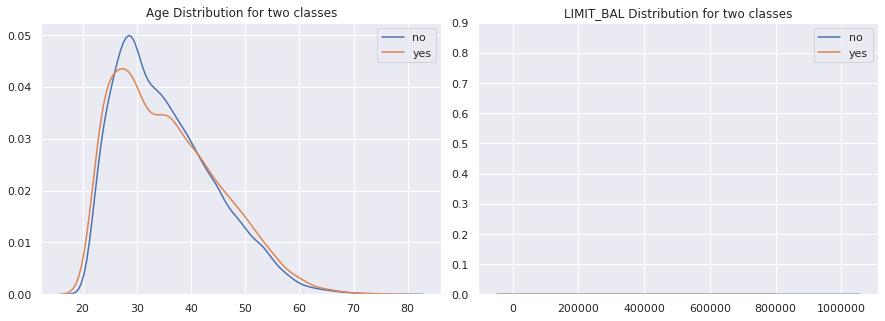

In [12]:
# Plot figure with subplots of different sizes
fig = plt.figure(1)
plt.figure(figsize=(15,5))# set up subplot grid
gridspec.GridSpec(1,4)
plt.subplot2grid((1,4), (0,0), colspan=2, rowspan=1)
sns.kdeplot(creditData.loc[creditData["default payment next month"]==0,"AGE"].values, label="no")
sns.kdeplot(creditData.loc[creditData["default payment next month"]==1,"AGE"].values, label="yes")
plt.legend();
plt.title("Age Distribution for two classes")
plt.subplot2grid((1,4), (0,2), colspan=2, rowspan=1)
sns.kdeplot(creditData.loc[creditData["default payment next month"]==0,"LIMIT_BAL"].values, label="no")
sns.kdeplot(creditData.loc[creditData["default payment next month"]==1,"LIMIT_BAL"].values, label="yes")
plt.ylim([0,0.9])
plt.legend();
plt.title("LIMIT_BAL Distribution for two classes")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d3f1b9350>,
      dtype=object)

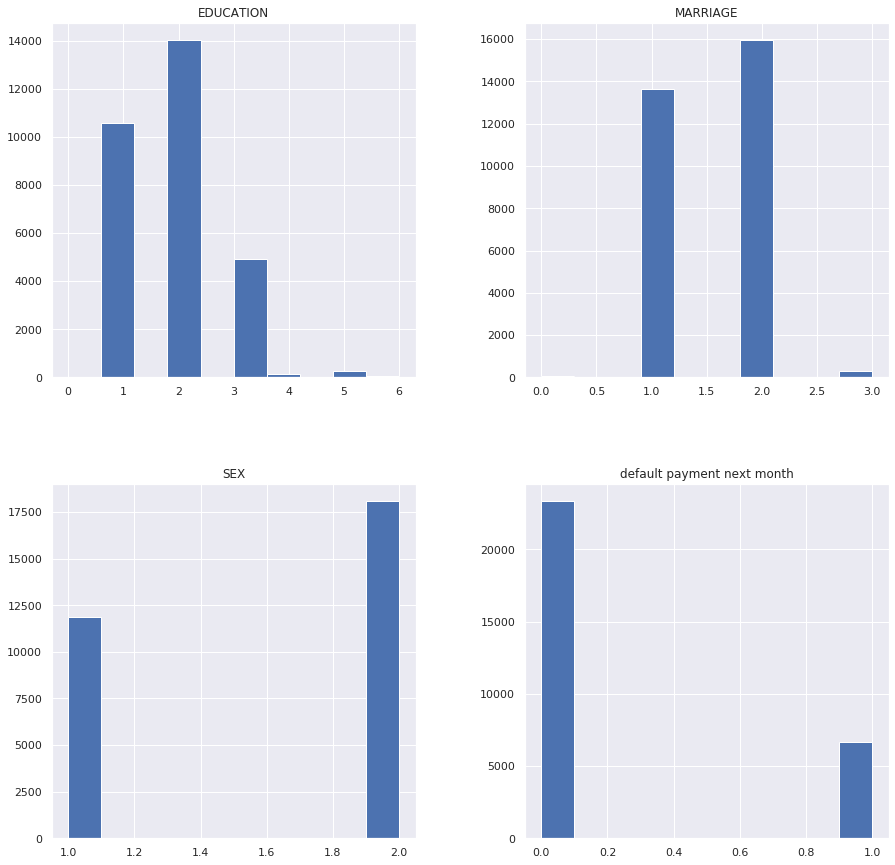

In [13]:
creditData[['SEX', 'EDUCATION', 'MARRIAGE','default payment next month']].hist(figsize=(15,15))


#### Variable Types:
1. Continuous:<br>
'LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
2. Categorical: <br>
'SEX', 'EDUCATION', 'MARRIAGE'
3. Target:<br>
'default.payment.next.month'

#### Preprocessing steps:
1. Normalizing Continuous variables
2. One Hot Encoding for Categorical

#### Data Pre-processesing

In [14]:
creditData.loc[creditData["SEX"]==2,"SEX"] = 2

In [15]:
ageGrps = list(range(20,85,5))
ageCrediters = pd.cut(creditData.AGE,ageGrps).to_frame()
ageCrediters.columns = ["AGE_RANGE"]
creditData = pd.concat([creditData,ageCrediters],axis=1)

In [16]:
creditData.AGE_RANGE = creditData.AGE_RANGE.astype('str')

#### One hot Encoding

In [17]:
df = pd.get_dummies(creditData["MARRIAGE"])
df.columns = ['MARRIAGE_unk','MARRIAGE_married', 'MARRIAGE_single','MARRIAGE_others']
creditData = pd.concat([creditData,df],axis=1)

In [18]:
creditData["EDUCATION_grad"] = 0
creditData["EDUCATION_university"] = 0
creditData["EDUCATION_hs"] = 0
creditData["EDUCATION_others"] = 0
creditData["EDUCATION_ukn"] = 0
creditData.loc[creditData["EDUCATION"]==1,"EDUCATION_grad"] = 1
creditData.loc[creditData["EDUCATION"]==2,"EDUCATION_university"] = 1
creditData.loc[creditData["EDUCATION"]==3,"EDUCATION_hs"] = 1
creditData.loc[creditData["EDUCATION"]==4,"EDUCATION_others"] = 1
creditData.loc[creditData["EDUCATION"]==5,"EDUCATION_ukn"] = 1
creditData.loc[creditData["EDUCATION"]==0,"EDUCATION_ukn"] = 1
creditData.loc[creditData["EDUCATION"]==6,"EDUCATION_ukn"] = 1


In [19]:
df = pd.get_dummies(creditData.AGE_RANGE)
df.columns = ['AGE_(20, 25]', 'AGE_(25, 30]', 'AGE_(30, 35]', 'AGE_(35, 40]', 'AGE_(40, 45]', 'AGE_(45, 50]','AGE_(50, 55]', 'AGE_(55, 60]', 'AGE_(60, 65]', 'AGE_(65, 70]', 'AGE_(70, 75]', 'AGE_(75, 80]']
creditData = pd.concat([creditData,df],axis=1)

#### Standardization

In [20]:
from sklearn.preprocessing import StandardScaler
creditData.loc[:, continuousCols] = StandardScaler().fit_transform(creditData.loc[:, continuousCols].values)

In [21]:
features = ['LIMIT_BAL', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'MARRIAGE_unk', 'MARRIAGE_married',
        'EDUCATION_grad',
       'EDUCATION_university', 'EDUCATION_others',
       'EDUCATION_ukn', 'AGE_(20, 25]', 'AGE_(25, 30]',
       'AGE_(30, 35]', 'AGE_(35, 40]', 'AGE_(40, 45]', 'AGE_(45, 50]',
       'AGE_(50, 55]', 'AGE_(55, 60]', 'AGE_(60, 65]', 'AGE_(65, 70]',
       'AGE_(70, 75]']

#### Correlation Analysis

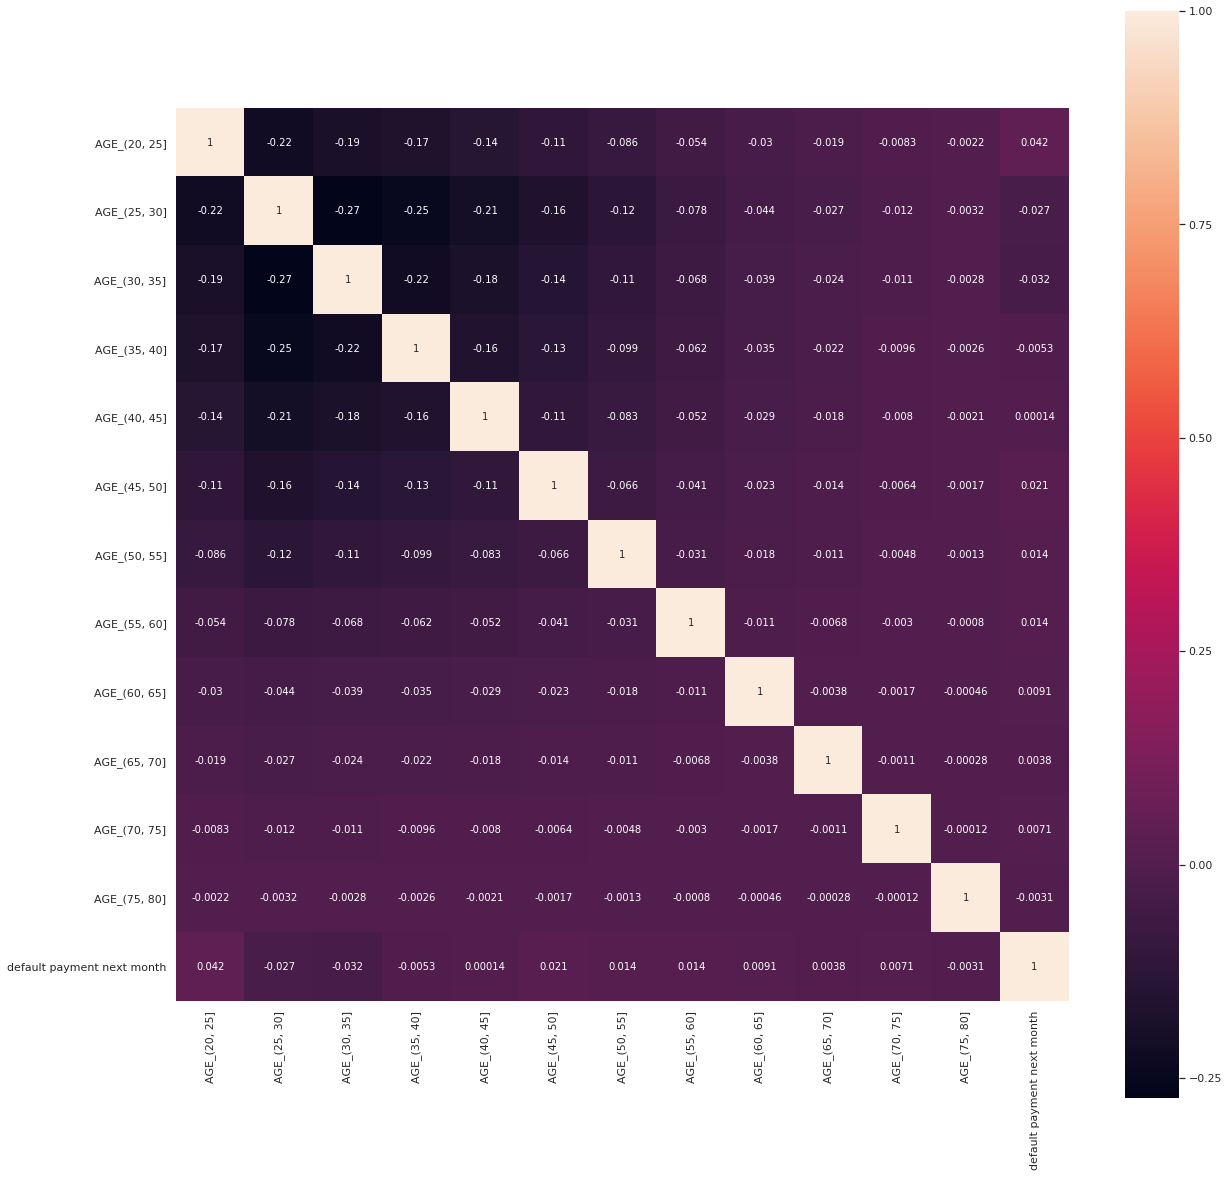

In [22]:
plt.figure(figsize=(20,20))
heat = sns.heatmap(creditData[['AGE_(20, 25]', 'AGE_(25, 30]',
       'AGE_(30, 35]', 'AGE_(35, 40]', 'AGE_(40, 45]', 'AGE_(45, 50]',
       'AGE_(50, 55]', 'AGE_(55, 60]', 'AGE_(60, 65]', 'AGE_(65, 70]',
       'AGE_(70, 75]', 'AGE_(75, 80]','default payment next month']].corr(), vmax=1, square=True, annot=True)

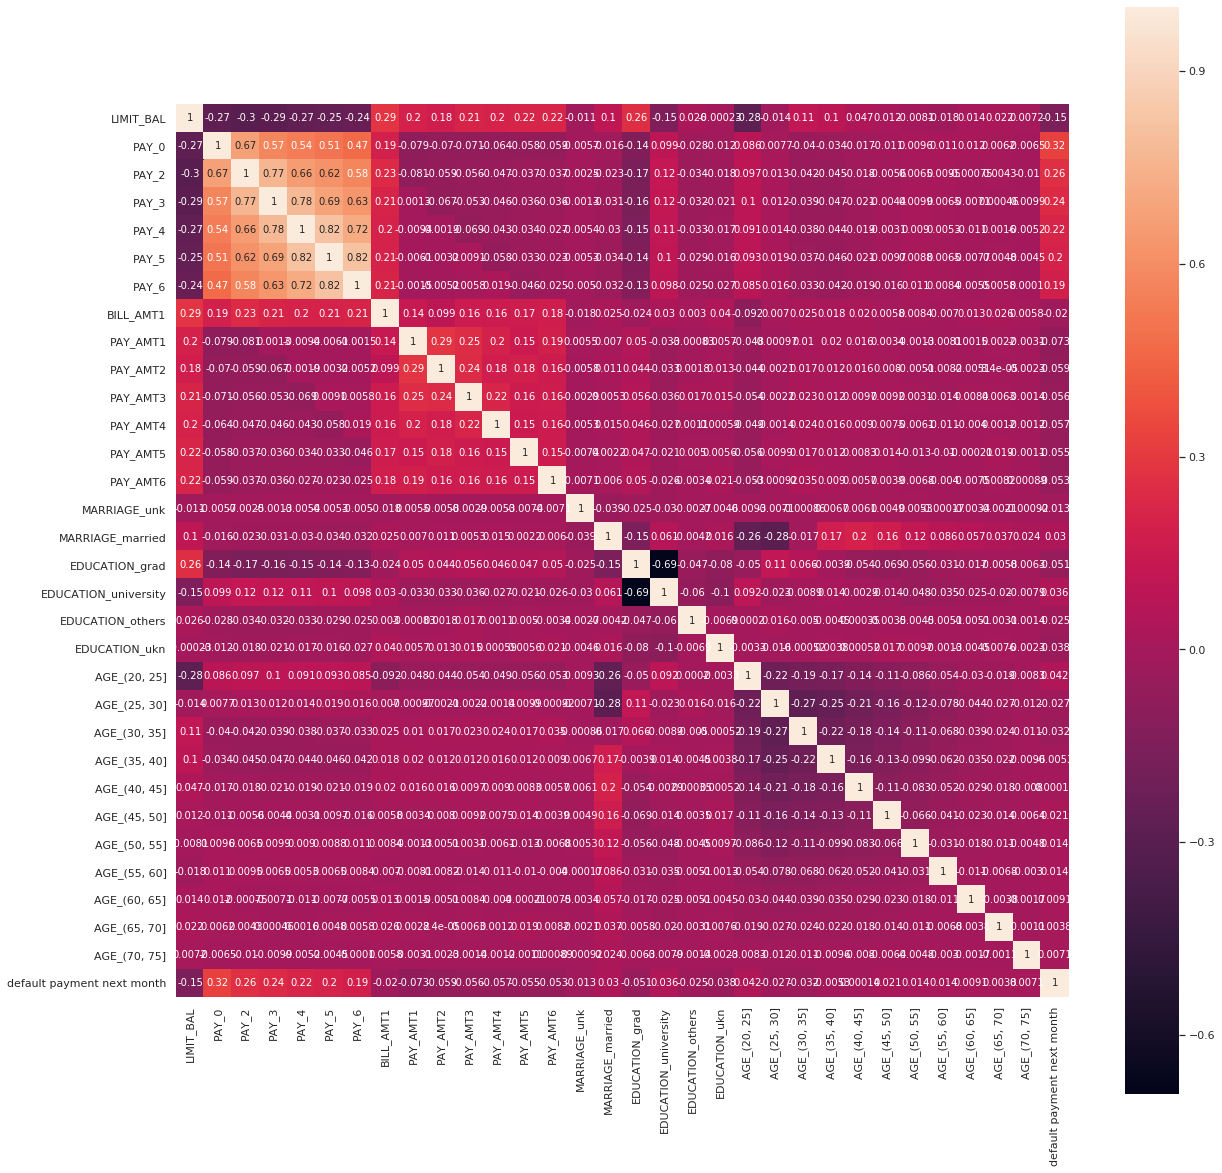

In [96]:
plt.figure(figsize=(20,20))
heat = sns.heatmap(creditData[features+["default payment next month"]].corr(), vmax=1, square=True, annot=True)


### Prepping data for model

In [24]:
data = creditData[features+["default payment next month"]]

In [25]:
trainData = data.sample(frac=.70) # random sampling of 70 of data
testData = data.loc[set(data.index)- set(trainData.index)] # picking the rest 30% of the data

In [26]:
XTrain = trainData[features].values
TTrain = trainData["default payment next month"].values
XTest = testData[features].values
TTest = testData["default payment next month"].values

# III. Methods

In this assignment, you are build a deep network with more than 5 layers using TensorFlow. 
Looking at the chart below, get some idea about how you can construct your networks for what problem and why you pick your structure. 

- Pick at least 3 different networks for experiments.
- Summarize the choice of your networks. 
- Explain your TensorFlow codes. 
- Explain how you apply your model to your data. 

Following images are only for you to get some idea. You do not necessarily stick with these. You can come up with your own structure or shape. 

![](https://camo.githubusercontent.com/31e20172e3b7bc5530a6e7c7e7339e8e556d0acc/687474703a2f2f7777772e6173696d6f76696e737469747574652e6f72672f77702d636f6e74656e742f75706c6f6164732f323031362f30392f6e657572616c6e6574776f726b732e706e67)



## A Straight graph based model
- 5 hidden + 1 input + 1 output layers
- All hidden layers have equal number of nodes
- Chose this to understand how tensorflow works and it would be simple

In [88]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 5
n_hidden2 = 5
n_hidden3 = 5
n_hidden4 = 5
n_hidden5 = 5
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.tanh, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.tanh, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.tanh, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.tanh, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.tanh, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    prediction = tf.argmax(logits, 1)

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 1000


In [28]:
show_graph(tf.get_default_graph())

array([[ 1.02135086, -0.87499115, -0.72356993, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.79209051,  0.01486052,  0.1117361 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.09646329,  0.01486052,  0.1117361 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.13672015,  0.01486052,  0.1117361 , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.713055  , -0.87499115,  1.78234817, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.48379465,  2.68441553,  1.78234817, ...,  0.        ,
         0.        ,  0.        ]])

In [91]:
n_epochs=1000
acc_train=[]
out = None
temp = []
pred = None
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))
    pred = sess.run(prediction, feed_dict={X: XTest, y: TTest})

Test Data Accuracy:  0.8011111


Text(0, 0.5, 'Accuracy Ratio')

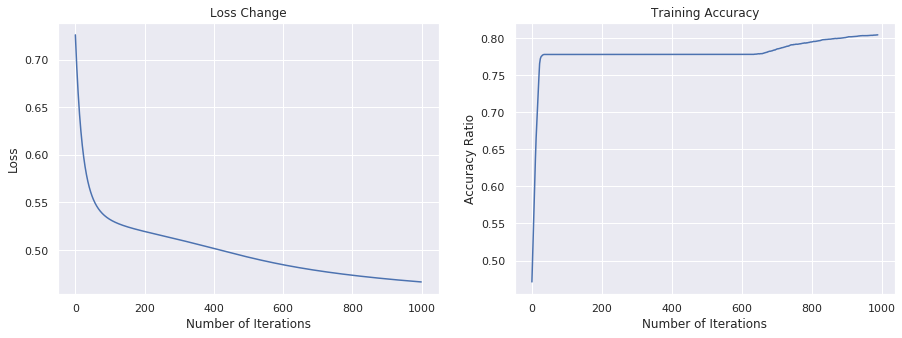

In [92]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

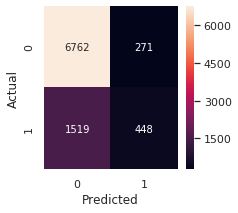

In [94]:
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# print(classification_report(y_pred=logits, y_true=TTest))

cm = confusion_matrix(TTest, pred)
plt.subplots(figsize=(3,3))
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### Increased Number of Iterations:
- Improved accuracy
- Takes longer
- Improvement was not too much, so we have take of the trade of

In [31]:
n_epochs=3000
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.8104445


Text(0, 0.5, 'Accuracy Ratio')

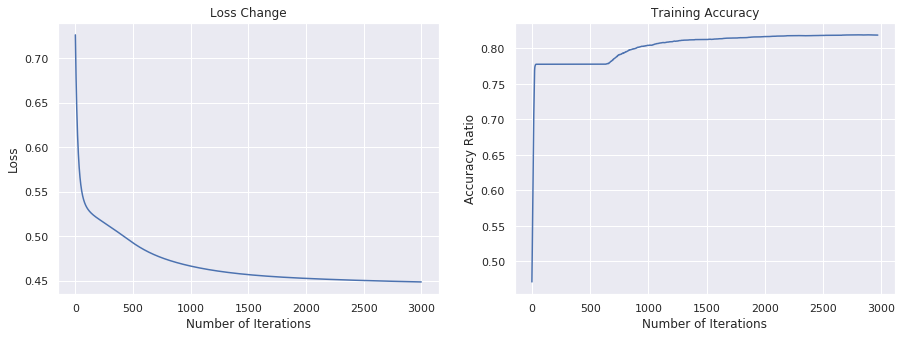

In [32]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

## Criss Cross and then narrowing
- 7 hidden (4 Criss Cross + 3 narrow ) + 1 input + 1 output layers
- Chose this structure to see how data expands and contracts (Encode and Decode) effect which later on converges

In [33]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 31
n_hidden2 = 16
n_hidden3 = 31
n_hidden4 = 16
n_hidden5 = 8
n_hidden6 = 6
n_hidden7 = 4
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=selu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=selu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=selu, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=selu, name="hidden6")
    hidden7 = tf.layers.dense(hidden6, n_hidden7, activation=selu, name="hidden7")
    logits = tf.layers.dense(hidden7, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [34]:
show_graph(tf.get_default_graph())

In [35]:
n_epochs = 1000

acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.8146667


Text(0, 0.5, 'Accuracy Ratio')

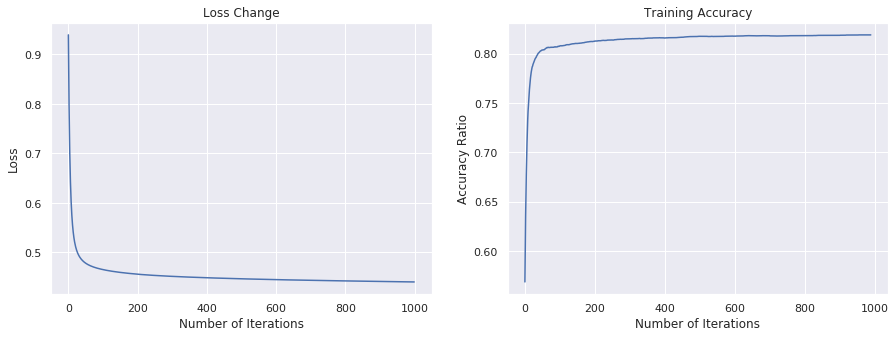

In [36]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

#### Increasing number of Iterations to a much significant number when number of layers have increased
- Here I see that accuracy remain unchanged
- But it takes a lot of time to finish training 

In [37]:
n_epochs = 10000

acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.814


Text(0, 0.5, 'Accuracy Ratio')

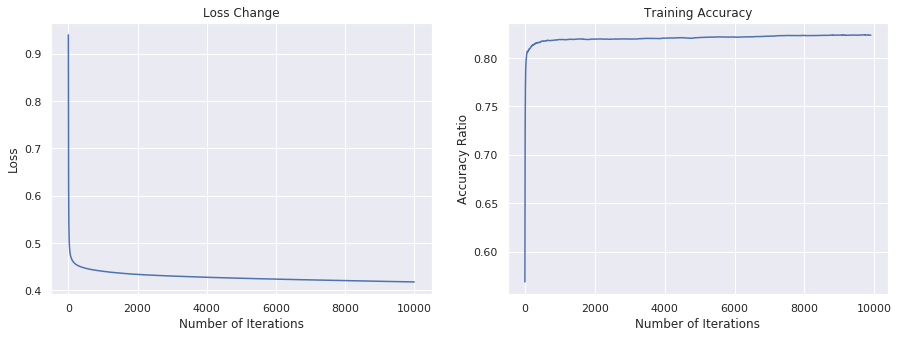

In [38]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

## Only Criss Cross 
- 6 hidden + 1 input + 1 output layers
- Chose this structure to see how data expands and contracts (Encode and Decode) effect alone

In [39]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 15
n_hidden2 = 5
n_hidden3 = 15
n_hidden4 = 5
n_hidden5 = 15
n_hidden6 = 5
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):

    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.tanh, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.tanh, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.tanh, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.tanh, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.tanh, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=tf.tanh, name="hidden6")
    logits = tf.layers.dense(hidden6, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 1000


In [40]:
show_graph(tf.get_default_graph())

In [41]:
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.8052222


Text(0, 0.5, 'Accuracy Ratio')

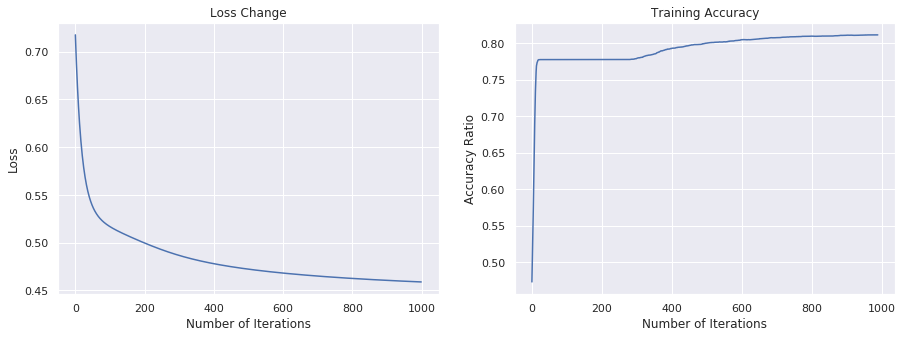

In [42]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

## Only Narrowing
- 6 hidden + 1 input + 1 output layers
- Chose this structure to see how echoing with reduced dimensionality of data affects classification

In [43]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 31
n_hidden2 = 25
n_hidden3 = 20
n_hidden4 = 15
n_hidden5 = 10
n_hidden6 = 5
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):

    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.tanh, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.tanh, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.tanh, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.tanh, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.tanh, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=tf.tanh, name="hidden6")
    logits = tf.layers.dense(hidden6, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 1000


In [44]:
show_graph(tf.get_default_graph())

In [45]:
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.8105556


Text(0, 0.5, 'Accuracy Ratio')

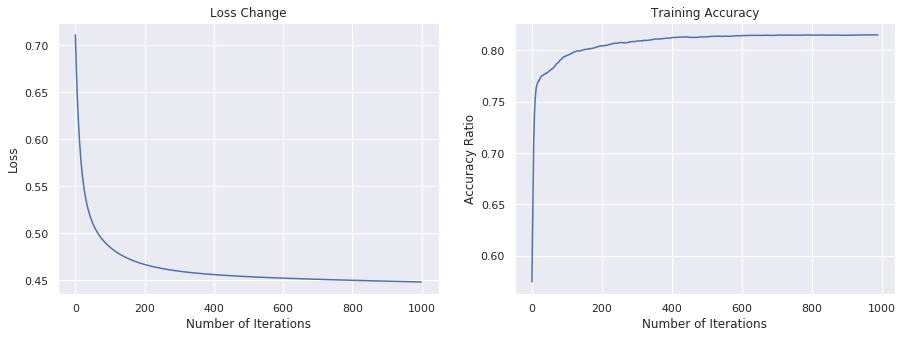

In [46]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

## Contraction and then Expansion
- 7 hidden + 1 input + 1 output layers
- First Data contracts for dew layers and then data expands
- Chose this structure to see how echoing with reduced dimensionality of data affects classification

In [47]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 20
n_hidden2 = 15
n_hidden3 = 10
n_hidden4 = 2
n_hidden5 = 10
n_hidden6 = 15
n_hidden7 = 20
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=selu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=selu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=selu, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=selu, name="hidden6")
    hidden7 = tf.layers.dense(hidden6, n_hidden7, activation=selu, name="hidden7")
    logits = tf.layers.dense(hidden7, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [48]:
show_graph(tf.get_default_graph())

In [49]:
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.80822223


Text(0, 0.5, 'Accuracy Ratio')

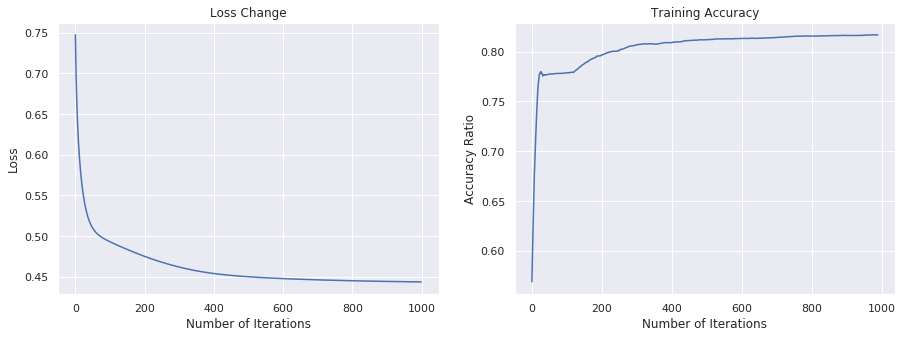

In [50]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

In [51]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 20
n_hidden2 = 15
n_hidden3 = 10
n_hidden4 = 2
n_hidden5 = 10
n_hidden6 = 15
n_hidden7 = 20
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.tanh, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.tanh, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.tanh, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.tanh, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.tanh, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=tf.tanh, name="hidden6")
    hidden7 = tf.layers.dense(hidden6, n_hidden7, activation=tf.tanh, name="hidden7")
    logits = tf.layers.dense(hidden7, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [52]:
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.81133336


Text(0, 0.5, 'Accuracy Ratio')

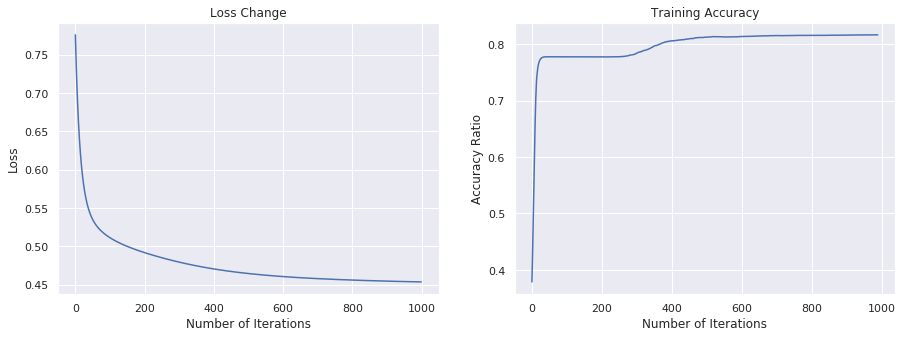

In [53]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

In [54]:
reset_graph()

n_inputs = XTrain.shape[1]
n_hidden1 = 20
n_hidden2 = 15
n_hidden3 = 10
n_hidden4 = 2
n_hidden5 = 10
n_hidden6 = 15
n_hidden7 = 20
n_outputs = 2

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=selu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=selu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=selu, name="hidden5")
    hidden6 = tf.layers.dense(hidden5, n_hidden6, activation=selu, name="hidden6")
    hidden7 = tf.layers.dense(hidden6, n_hidden7, activation=selu, name="hidden7")
    logits = tf.layers.dense(hidden7, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.AdamOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [55]:
acc_train=[]
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.8066667


Text(0, 0.5, 'Accuracy Ratio')

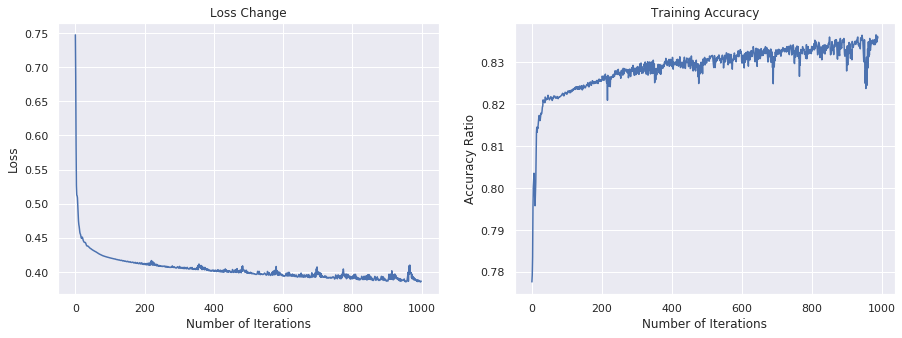

In [56]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,2,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

#### Checking how testing accuracy after every 100 iterations

In [57]:
acc_train=[]
acc_test = []
out = None
temp = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        temp.append(sess.run([loss,training_op], feed_dict={X: XTrain, y: TTrain}))
        if epoch % 100:
            acc_train.append(accuracy.eval(feed_dict={X: XTrain, y: TTrain}))
            acc_test.append(accuracy.eval(feed_dict={X: XTest, y: TTest}))
    print("Test Data Accuracy: ",accuracy.eval(feed_dict={X: XTest, y: TTest}))

Test Data Accuracy:  0.8066667


Text(0, 0.5, 'Accuracy Ratio')

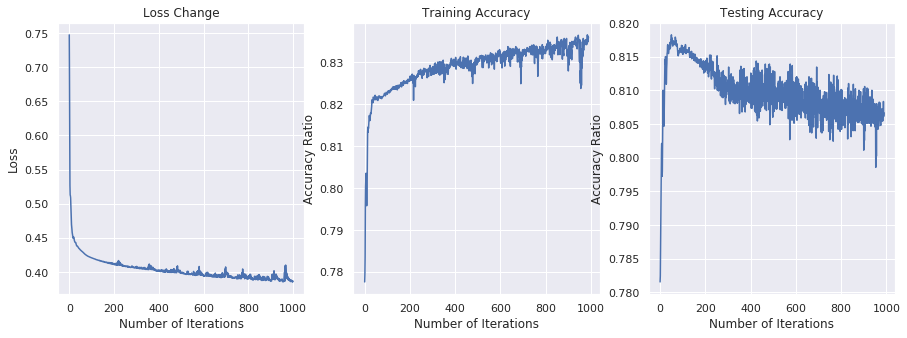

In [58]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(np.array(temp)[:,0])
plt.title("Loss Change")
plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.subplot(1,3,2)
plt.plot(acc_train)
plt.title("Training Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")
plt.subplot(1,3,3)
plt.plot(acc_test)
plt.title("Testing Accuracy")
plt.xlabel("Number of Iterations")
plt.ylabel("Accuracy Ratio")

# IV - Results

- Presents the results of applications of your deep networks.
- Visualize the results 
- Discuss about the choice of network structures and performance of it as you change the structures.  
- What do you think about the results? 

### Results Discussion: (All for this dataset*****)
    - All these structures gave me accuracies that were very close to each other
    - Contraction and then Expansion gave the best result, so I will change some parameters and see if value changes
    - You see sudden improvement in training accuracy and quick drop in loss as well
    - Iterations is not the cause for this accuracy
    - If we compare at 500 iteration then we can wee that 2 structures are still trying to learn and improve but other structures just learn very quickly and then become stable
    - Adam Optimizer is slow than Gradient Descent
        - It fluctuates a lot
    - Relu is better than tanh also tested

### Results Visualized while running each layer
    - Already Done while implementing


### Understanding the structure with personal Biases
    - Now, I was trying to form structures by some intuional assumptions but I have no idea if that makes sense.
    - Idea is that each layer is useful in understanding the data
    - Adding more layer means finding some of the combinations of these columns aggregated based on some weights.
    - Now, I interpreted reducing number of nodes in a layer means reducing dimentionality and vice versa

### My opinions
    - I guess these structures are giving very similar results because small number of data points.
    - Or it can be some parameters as well.

# Conclusions

Discuss the challenges or somethat that you learned. 
If you have any suggestion about the assignment, you can write about it. 

- Challenges:
    - Understanding how flow is created and then how it is executed
    - I was trying to implement different types of nodes (memory, rnn, convolutional) but lacked the knowledge to
    
- Learning:
    - Learnt how to create a DNN with feed-forward and back propagation
    - Network structures have some meaning behind them
    - Increasing iterations doesn't necessarily mean accuracy improves
    - Considering the trade offs, take necessary hyper parameters
    - Try and test different Nets

# Extra Credit

- Test your program with GPUs and compare training speed. You can try [FloydHub](https://www.floydhub.com/) for free 2 hours of GPU resources. 

## Grading

DO NOT forget to submit your data! Your notebook is supposed to run fine after running your codes. 


points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
15 | Data | 
 | 5| Includes description of your data
 | 5| Plots to visualize data 
 | 5| Reading and analyzing the plots 
50 | Methods | 
 | 30| Explanation of the choice for 3 different neural network structures and reason for the selection. (10 points for each) 
 |   | Relate the choice of your data!
 | 15| Explanation of codes for each structure
 |  5| Explanation of experimental codes
25 | Results | Your Data
| 15| plots for results 
| 10| Discussions about the choice of network structures 
5 | Conclusions 
